In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
from sklearn.neighbors import NearestCentroid

In [2]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [3]:
from sklearn.neighbors import DistanceMetric


def gower_distance(X):
    """
    This function expects a pandas dataframe as input
    The data frame is to contain the features along the columns. Based on these features a
    distance matrix will be returned which will contain the pairwise gower distance between the rows
    All variables of object type will be treated as nominal variables and the others will be treated as 
    numeric variables.
    Distance metrics used for:
    Nominal variables: Dice distance (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
    Numeric variables: Manhattan distance normalized by the range of the variable (https://en.wikipedia.org/wiki/Taxicab_geometry)
    """
    individual_variable_distances = []

    for i in range(X.shape[1]):
        feature = X.iloc[:,[i]]
        if feature.dtypes[0] == np.object:
            feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)

        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

def cluster_score(data_encoded_clustered, metric):
    
    cluster_total = 0
    for cluster in data_encoded_clustered['Cluster'].unique():

        cluster_set = data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster]
        
        cols = list(data_encoded_clustered.columns)
        cols.remove('Cluster')
        
        if len(data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster]) == 1:

            cluster_total = 0
        else:
            
            if metric == 'gower':

                cluster_dist = gower_distance(data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster][cols]).sum()
                
            elif metric == 'euclidean':
                
                euclidean_df = data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster][cols]
                
                cluster_dist = euclidean_distances(euclidean_df, euclidean_df).sum()            

        cluster_total = cluster_total + cluster_dist
        
    return cluster_total

In [5]:
def centroid_calc(data_encoded_clustered, cont_cols):
     
    clf = NearestCentroid()
    clf.fit(data_encoded_clustered[cont_cols], data_encoded_clustered['Cluster'])

    return clf.centroids_

In [6]:
def sum_of_squares(centroids, data_encoded_clustered,clustering_cols):
    
    total_dist = 0
    for cluster in range(centroids.shape[0]):

        centroid_dist = 0
        for i in list(data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster].index):

            centroid_dist = centroid_dist + np.square(list(data_encoded_clustered[clustering_cols].loc[i]) - centroids[cluster]).sum()

        total_dist = total_dist + centroid_dist
    return total_dist

In [20]:
data = pd.read_excel('abaloneCleaned.xlsx')

In [21]:
cont_cols =['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']

In [22]:
# data_prof = ProfileReport(data)
# data_prof.to_file(output_file='data_profile.html')

In [23]:
# sns.set_theme(style="white")
# sns.pairplot(data[cont_cols])
# plt.savefig('images/01 splom before.png',bbox_inches = 'tight');

In [24]:
remove_height = list(data[(data['Height'] <= np.percentile(data['Height'], 0.001)) | (data['Height'] > np.percentile(data['Height'], 99.95))].index)
data = data[data.index.isin(remove_height) == False].reset_index(drop=True)

In [25]:
# sns.set_theme(style="white")
# sns.pairplot(data[cont_cols])
# plt.savefig('images/02 splom after.png',bbox_inches = 'tight');

#### Obtain Correlation Matrix

In [26]:
data.corr().to_csv('cor_matrix.csv')

#### Separate target variable from the dataset

In [27]:
target = data['Rings']
data = data.drop('Rings', axis=1)

#### Perform scaling and encoding

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data[cont_cols] = scaler.fit_transform(data[cont_cols])

In [29]:
data_encoded = pd.get_dummies(data)

In [30]:
data_encoded.to_csv('scaled_features.csv',index=False)

#### Obtain Hopkins Stat and VAT

In [31]:
from pyclustertend import hopkins
hopkins(data_encoded[cont_cols],len(data_encoded))

0.0547957384900215

In [32]:
sample = list(np.random.choice(range(len(data_encoded)), 150, replace=False))
data_sample = data_encoded[cont_cols].loc[sample].reset_index(drop=True)

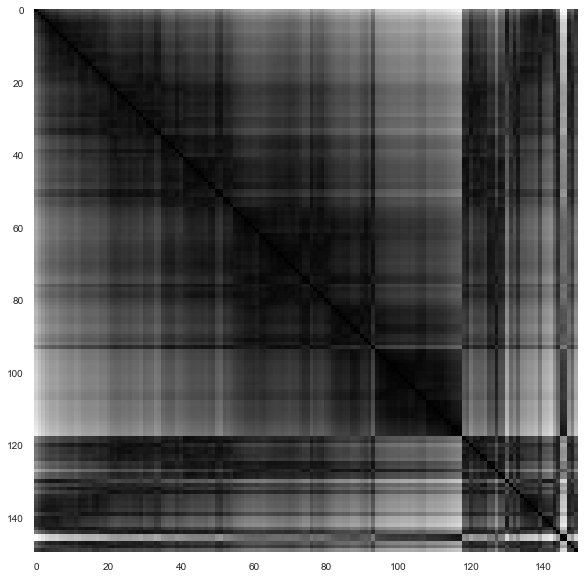

In [33]:
from pyclustertend import vat
vat(data_sample)
plt.savefig('images/03 VAT.png',bbox_inches = 'tight');

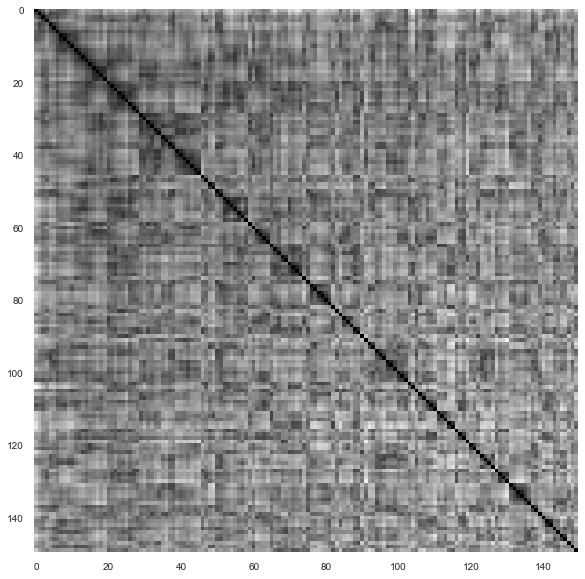

In [34]:
random_df = pd.DataFrame(np.random.rand(150,len(cont_cols)), columns = cont_cols)
vat(random_df)
plt.savefig('images/04 Random_VAT.png',bbox_inches = 'tight');

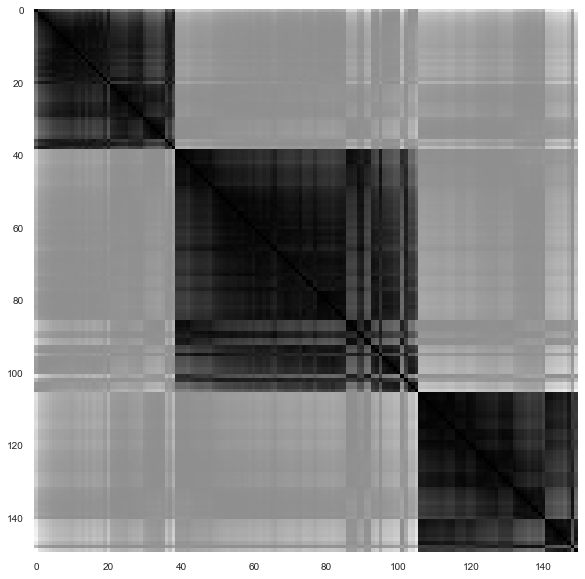

In [35]:
sample = list(np.random.choice(range(len(data_encoded)), 150, replace=False))
data_sample = data_encoded.loc[sample].reset_index(drop=True)
from pyclustertend import vat
vat(data_sample)
plt.savefig('images/05 VAT with cat.png',bbox_inches = 'tight');

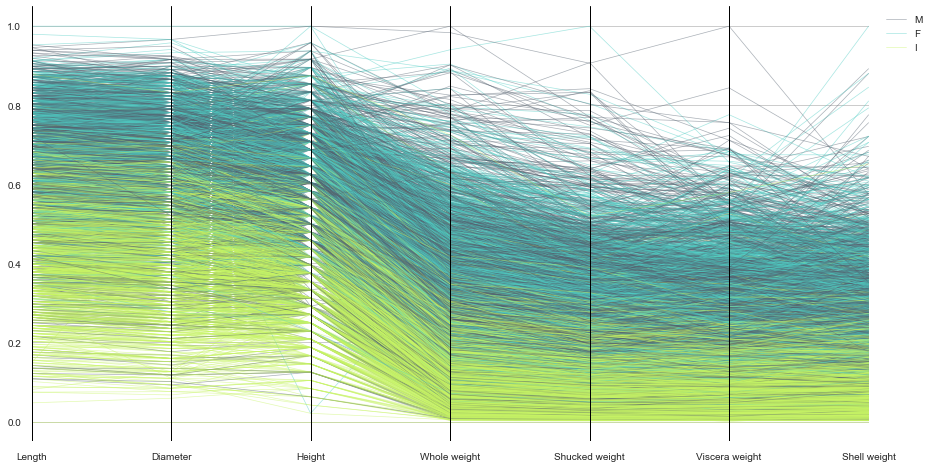

In [33]:
plt.figure(figsize=(15, 8))
pd.plotting.parallel_coordinates(data, 'Gender',color=('#556270', '#4ECDC4', '#C7F464'),linewidth=0.7,alpha=0.5)
plt.legend(loc=1,bbox_to_anchor=(1.075, 1),fancybox =1, shadow =True, framealpha =0.8)
plt.savefig('images/06 Parallel Gender.png',bbox_inches = 'tight');

In [36]:
clustering_cols = ['Diameter', 'Height', 'Shell weight']

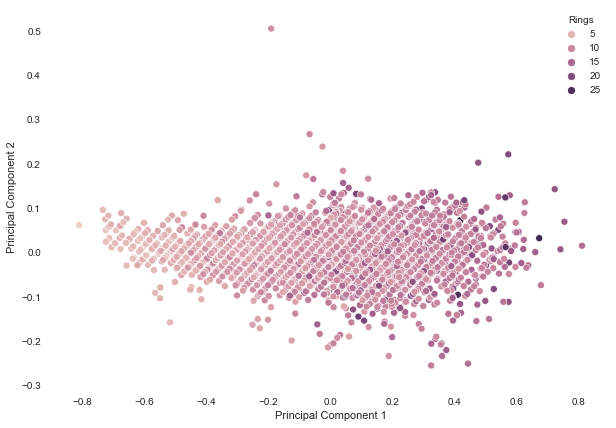

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_encoded[clustering_cols])

principal_df = pd.DataFrame(data = principalComponents , columns = ['Principal Component 1', 'Principal Component 2'])
finalDf = pd.concat([principal_df, data['Gender']], axis = 1)
# finalDf = pd.concat([principal_df, target], axis = 1)

plt.figure(figsize=(10, 7))
sns.scatterplot(x='Principal Component 1', y= 'Principal Component 2', hue=target, data=finalDf)
plt.savefig('images/07 PCA Rings Scatter.png',bbox_inches = 'tight');

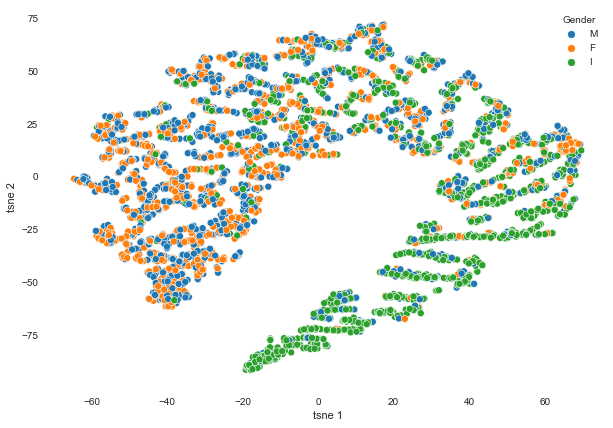

In [38]:
from sklearn.manifold import TSNE
data_tsne = TSNE(n_components=2).fit_transform(data_encoded[clustering_cols])

tsne_df = pd.DataFrame(data = data_tsne , columns = ['tsne 1', 'tsne 2'])
tsne_df_final = pd.concat([tsne_df, data['Gender']], axis = 1)
# tsne_df_final = pd.concat([tsne_df, target], axis = 1)

plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne 1', y= 'tsne 2', hue='Gender', data=tsne_df_final)
plt.savefig('images/08 tsne gender Scatter.png',bbox_inches = 'tight');

#### Feature Selection

In [39]:
# Feature Selection with Univariate Statistical Tests
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature extraction
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(data_encoded[cont_cols], target)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(data_encoded[cont_cols])
# summarize selected features
print(features[0:5,:])

[188.153 196.067 174.324 113.609  80.733 103.588 147.642]
[[0.514 0.521 0.354 0.148]
 [0.372 0.353 0.333 0.068]
 [0.615 0.613 0.521 0.208]
 [0.493 0.521 0.479 0.153]
 [0.345 0.336 0.292 0.053]]


In [40]:
cont_cols.append('Rings')

In [41]:
clustering_cols_gender = ['Diameter', 'Height', 'Shell weight','Gender_F', 'Gender_I', 'Gender_M']

In [42]:
data_encoded['Gender_F'] = data_encoded['Gender_F'].astype(object)
data_encoded['Gender_M'] = data_encoded['Gender_M'].astype(object)
data_encoded['Gender_I'] = data_encoded['Gender_I'].astype(object)

In [43]:
gower = gower_distance(data_encoded[clustering_cols_gender])

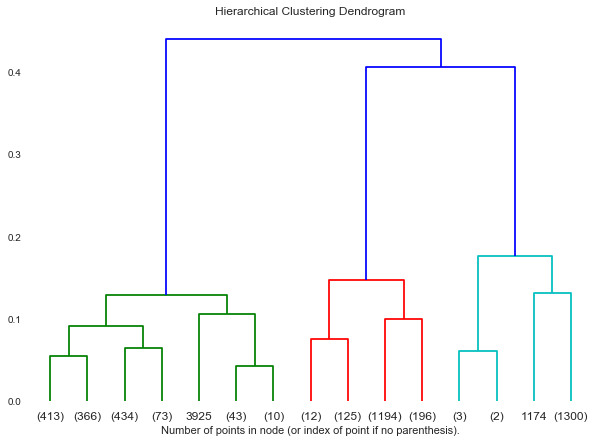

In [44]:
from sklearn.cluster import AgglomerativeClustering
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="precomputed", linkage="average")

model = model.fit(gower)

plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()
plt.savefig('images/08 Dendogram.png',bbox_inches = 'tight');

In [45]:
from sklearn.cluster import AgglomerativeClustering

elbow_df = pd.DataFrame(columns=['n_clusters', 'gower_total'])
i = 0
for n_clusters in range(1,11):
    gower_total = 0
    
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity="precomputed", linkage="average")
    model = model.fit(gower)
    
    data_encoded_clustered = pd.concat([data_encoded,pd.Series(model.labels_)], axis=1)
    data_encoded_clustered = data_encoded_clustered.rename(columns={0:'Cluster'})
    
    gower_total = cluster_score(data_encoded_clustered, metric='gower')
    
    elbow_df.loc[i,'n_clusters'] = n_clusters
    elbow_df.loc[i,'gower_total'] = gower_total
    
    i = i +1
    
    del data_encoded_clustered

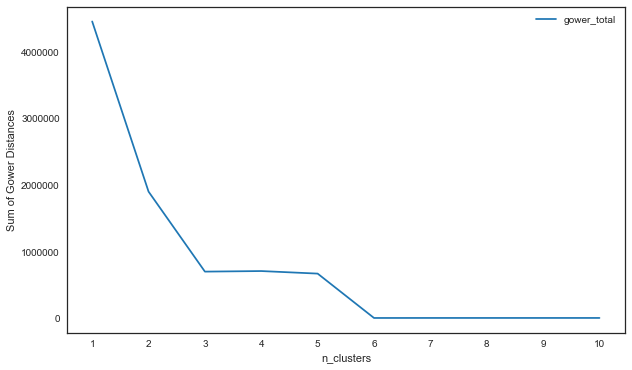

In [46]:
plt.style.use('seaborn-white')
elbow_df.plot.line(x='n_clusters',y='gower_total',xticks=range(1,11),figsize=(10,6),ylabel="Sum of Gower Distances")
plt.savefig('images/09 Gower Elbow.png',bbox_inches = 'tight');

In [47]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

elbow_df = pd.DataFrame(columns=['n_clusters', 'sum_square_total', 'silhouette_avg'])
i = 0
# cluster_total = 0 
for n_clusters in range(2,15):
    
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="ward")
    model = model.fit(data_encoded[clustering_cols])
    
    data_encoded_clustered = pd.concat([data_encoded[clustering_cols],pd.Series(model.labels_)], axis=1)
    data_encoded_clustered = data_encoded_clustered.rename(columns={0:'Cluster'})
    
    centroids = centroid_calc(data_encoded_clustered, clustering_cols)

    elbow_df.loc[i,'sum_square_total'] = sum_of_squares(centroids, data_encoded_clustered,clustering_cols)
    elbow_df.loc[i,'n_clusters'] = n_clusters
    elbow_df.loc[i,'silhouette_avg'] = silhouette_score(data_encoded_clustered[clustering_cols], data_encoded_clustered['Cluster'])
    
    i = i +1
    
#     del data_encoded_clustered

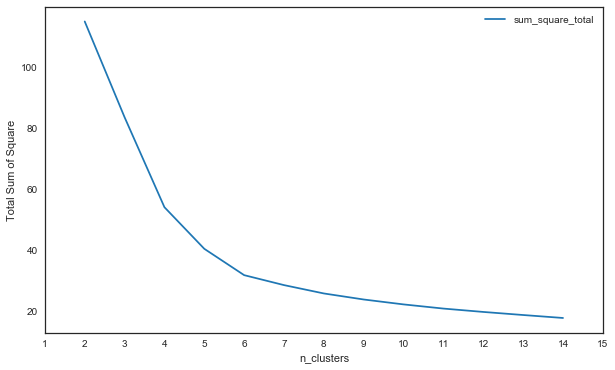

In [48]:
plt.style.use('seaborn-white')
elbow_df.plot.line(x='n_clusters',y='sum_square_total',xticks=range(1,16),figsize=(10,6),ylabel="Total Sum of Square")
plt.savefig('images/09 Sum Square Elbow.png',bbox_inches = 'tight');

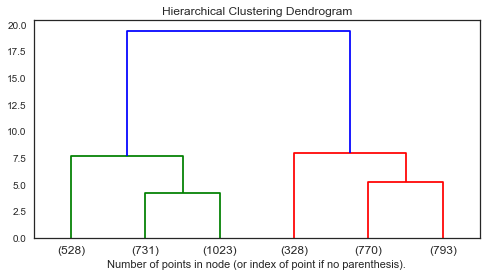

In [49]:
from sklearn.cluster import AgglomerativeClustering
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity="euclidean", linkage="ward")

model = model.fit(data_encoded[clustering_cols])

plt.figure(figsize=(8, 4))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='lastp', p=6)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()
plt.savefig('images/08 Dendogram.png',bbox_inches = 'tight');

In [130]:
final_model = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="ward")
final_model = final_model.fit(data_encoded[clustering_cols])

data_encoded_clustered = pd.concat([data_encoded[clustering_cols],pd.Series(final_model.labels_)], axis=1)
data_encoded_clustered = data_encoded_clustered.rename(columns={0:'Cluster'})
data_encoded_clustered = pd.concat([data_encoded_clustered,target], axis=1)

centroids = centroid_calc(data_encoded_clustered, clustering_cols)

In [122]:
pd.DataFrame(centroids).to_csv('centroids.csv')

In [123]:
for i in range(centroids.shape[0]):
    
    data_encoded_clustered[data_encoded_clustered['Cluster'] == i].describe().to_csv('desc_stats/desc_stats_' + str(i) + '.csv')

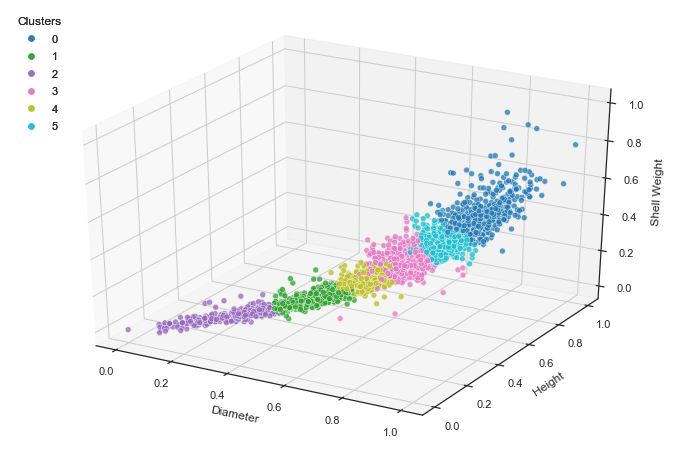

In [131]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')



scatter = ax.scatter(data_encoded_clustered['Diameter'], data_encoded_clustered['Height'], data_encoded_clustered['Shell weight'], c=data_encoded_clustered['Cluster'], cmap='tab10',alpha=0.75,edgecolors='w',linewidths=0.5,s=35);
ax.set(xlabel='Diameter', ylabel='Height', zlabel = 'Shell Weight')
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 10

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Clusters")
ax.add_artist(legend1)
plt.savefig('images/09 3D Clusters Scatter.png',bbox_inches = 'tight');

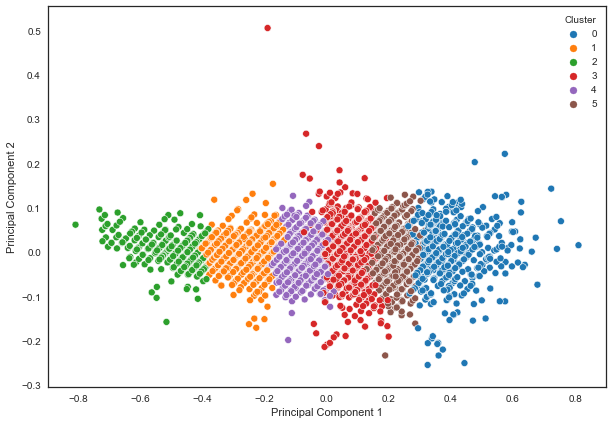

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_encoded[clustering_cols])

principal_df = pd.DataFrame(data = principalComponents , columns = ['Principal Component 1', 'Principal Component 2'])
finalDf = pd.concat([principal_df, data_encoded_clustered['Cluster']], axis = 1)
# finalDf = pd.concat([principal_df, target], axis = 1)

plt.figure(figsize=(10, 7))
sns.scatterplot(x='Principal Component 1', y= 'Principal Component 2', hue='Cluster', data=finalDf, palette='tab10')
plt.savefig('images/09 PCA Clusters Scatter.png',bbox_inches = 'tight');

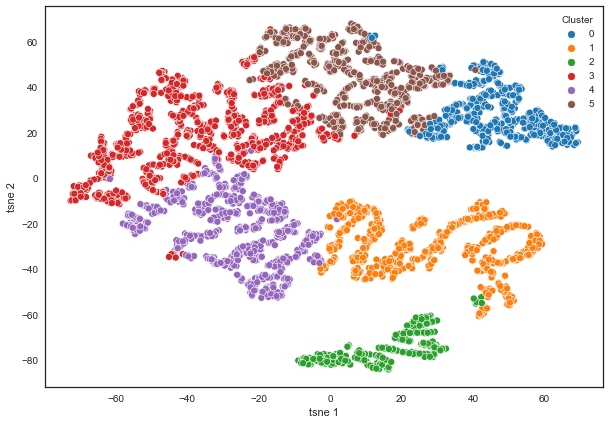

In [54]:
from sklearn.manifold import TSNE
data_tsne = TSNE(n_components=2).fit_transform(data_encoded[clustering_cols])

tsne_df = pd.DataFrame(data = data_tsne , columns = ['tsne 1', 'tsne 2'])
tsne_df_final = pd.concat([tsne_df, data_encoded_clustered['Cluster']], axis = 1)
# tsne_df_final = pd.concat([tsne_df, target], axis = 1)

plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne 1', y= 'tsne 2', hue='Cluster', data=tsne_df_final, palette='tab10')
plt.savefig('images/08 tsne Cluster Scatter.png',bbox_inches = 'tight');

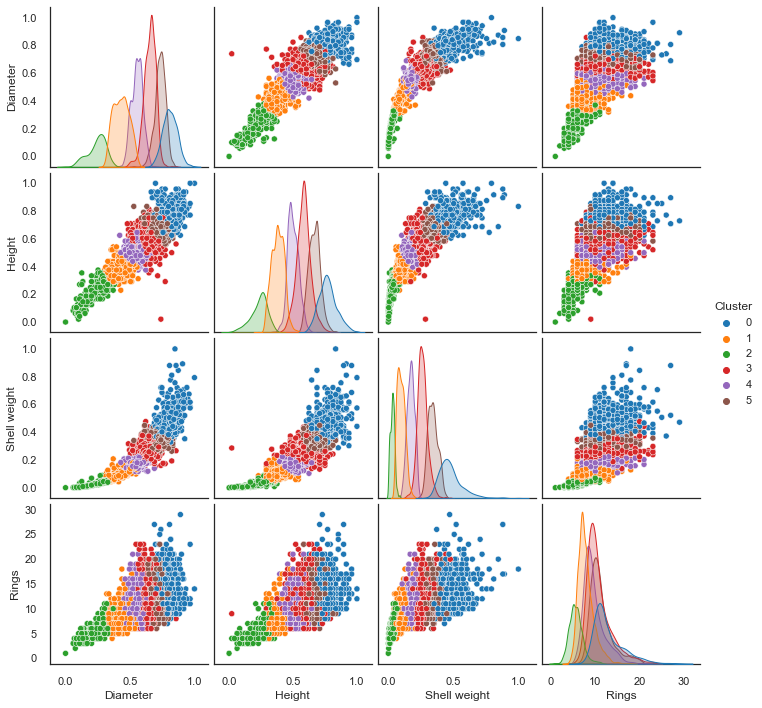

In [132]:
sns.set_theme(style="white")
sns.pairplot(data_encoded_clustered, hue='Cluster', palette='tab10')
plt.savefig('images/11 splom after clustering.png',bbox_inches = 'tight');

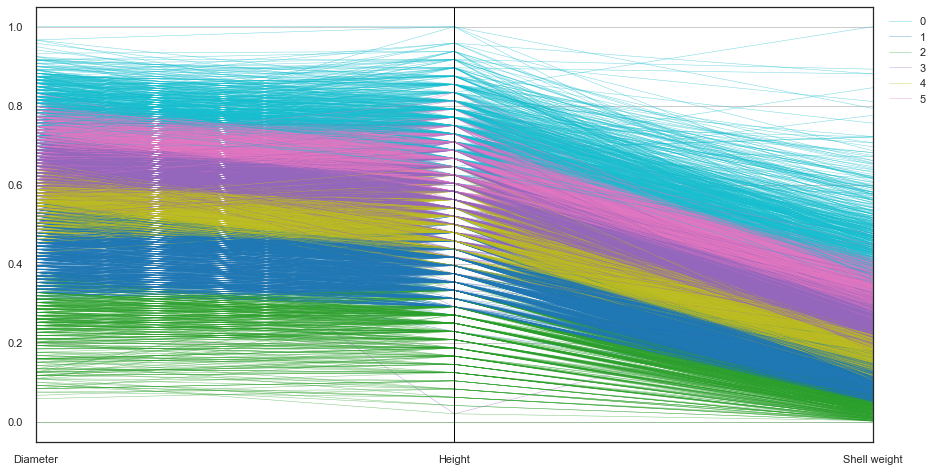

In [139]:
plt.figure(figsize=(15, 8))
pd.plotting.parallel_coordinates(data_encoded_clustered[['Diameter', 'Height', 'Shell weight', 'Cluster']], 'Cluster', colormap='tab10',sort_labels=1, linewidth=0.5, alpha=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,5,2,1,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=1,bbox_to_anchor=(1.075, 1),fancybox =1, shadow =True, framealpha =0.8)

plt.savefig('images/012 Parallel Clusters.png',bbox_inches = 'tight');

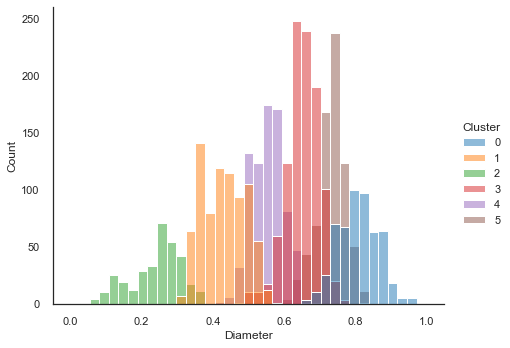

In [72]:
sns.displot(data_encoded_clustered, x="Diameter", hue="Cluster", palette='tab10',aspect=1.3)
plt.savefig('images/12 Diameter Hist.png',bbox_inches = 'tight');

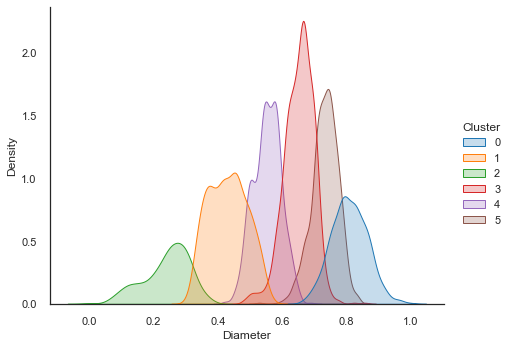

In [73]:
sns.displot(data_encoded_clustered, x="Diameter", hue="Cluster", palette='tab10', kind="kde",fill=True,aspect=1.3)
plt.savefig('images/12 Diameter KDE.png',bbox_inches = 'tight');

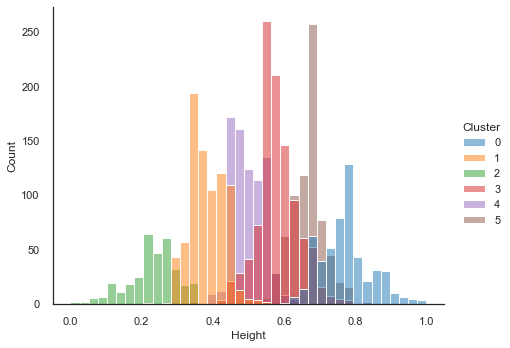

In [74]:
sns.displot(data_encoded_clustered, x="Height", hue="Cluster", palette='tab10',aspect=1.3)
plt.savefig('images/13 Height Hist.png',bbox_inches = 'tight');

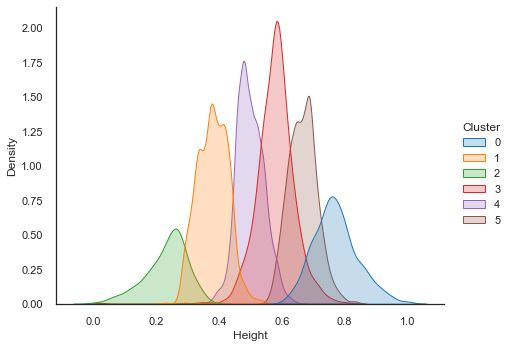

In [85]:
ax = sns.displot(data_encoded_clustered, x="Height", hue="Cluster", palette='tab10', kind="kde",fill=True,aspect=1.3)
plt.savefig('images/13 Height KDE.png',bbox_inches = 'tight');

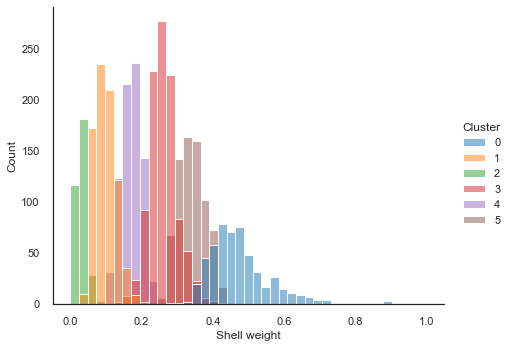

In [97]:
sns.displot(data_encoded_clustered, x="Shell weight", hue="Cluster", palette='tab10',aspect=1.3)
plt.savefig('images/14 Shell weight Hist.png',bbox_inches = 'tight');

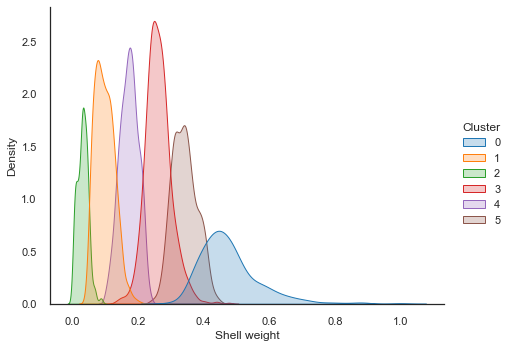

In [98]:
sns.displot(data_encoded_clustered, x="Shell weight", hue="Cluster", palette='tab10', kind="kde",fill=True,aspect=1.3)
plt.savefig('images/14 Shell weight KDE.png',bbox_inches = 'tight');

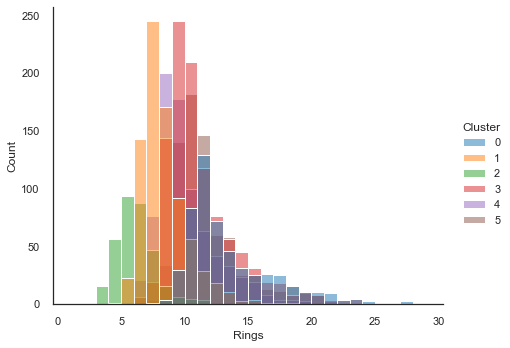

In [99]:
sns.displot(data_encoded_clustered, x="Rings", hue="Cluster", palette='tab10',aspect=1.3, kind="hist",binwidth=1)
plt.savefig('images/15 Rings Hist.png',bbox_inches = 'tight');

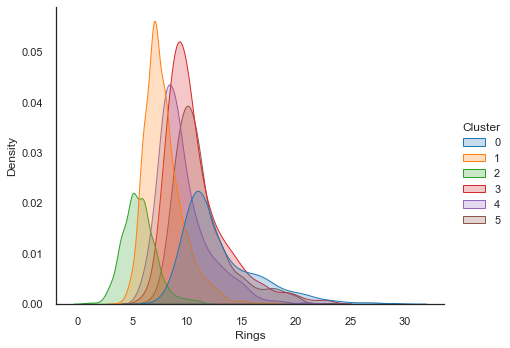

In [137]:
sns.displot(data_encoded_clustered, x="Rings", hue="Cluster", palette='tab10', kind="kde",fill=True,aspect=1.3)
plt.savefig('images/15 Rings KDE.png',bbox_inches = 'tight');

In [148]:
for i in range(len(data_encoded_clustered)):
    
    if data_encoded_clustered.loc[i,'Rings'] <= 6:
        
        data_encoded_clustered.loc[i,'Classified'] = 0.75
    
    elif data_encoded_clustered.loc[i,'Rings'] <= 9:
        
        data_encoded_clustered.loc[i,'Classified'] = 0.50
        
    elif data_encoded_clustered.loc[i,'Rings'] <= 10:
        
        data_encoded_clustered.loc[i,'Classified'] = 1
    
    else: data_encoded_clustered.loc[i,'Classified'] = 0.25

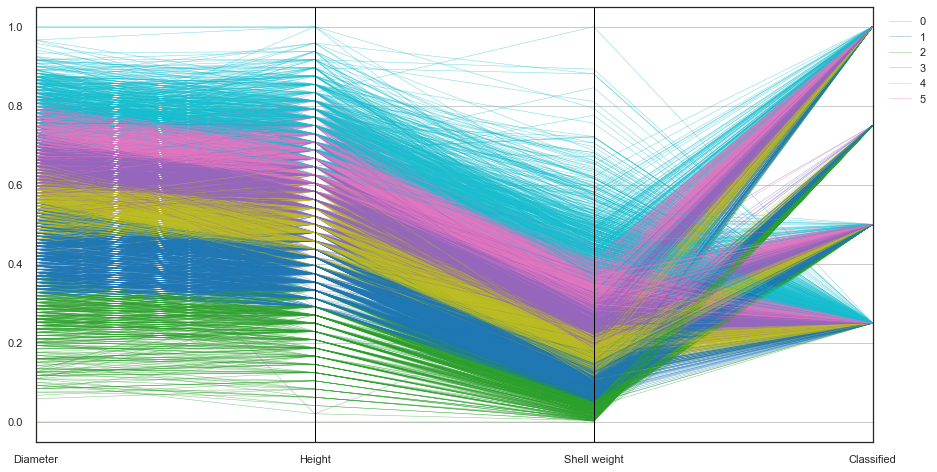

In [149]:
plt.figure(figsize=(15, 8))
pd.plotting.parallel_coordinates(data_encoded_clustered[['Diameter', 'Height', 'Shell weight', 'Cluster', 'Classified']], 'Cluster', colormap='tab10',sort_labels=1, linewidth=0.5, alpha=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,5,2,1,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=1,bbox_to_anchor=(1.075, 1),fancybox =1, shadow =True, framealpha =0.8)

plt.savefig('images/013 Parallel Clusters with classification.png',bbox_inches = 'tight');

In [142]:
data_encoded_clustered.loc[0,'Rings']

15

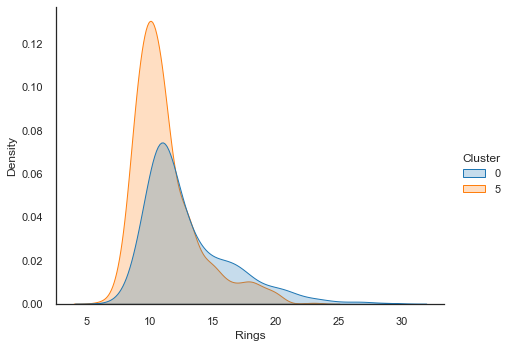

In [138]:
test = data_encoded_clustered[data_encoded_clustered['Cluster'].isin([0,5])]
sns.displot(test, x="Rings", hue="Cluster", palette='tab10', kind="kde",fill=True,aspect=1.3)
plt.savefig('images/16 Rings KDE CLuster 0 and 5.png',bbox_inches = 'tight');

In [106]:
data_encoded

Length  Diameter    Height  Whole weight  Shucked weight  \
0     0.513514  0.521008  0.354167      0.181335        0.150303   
1     0.371622  0.352941  0.333333      0.079157        0.066241   
2     0.614865  0.613445  0.520833      0.239065        0.171822   
3     0.493243  0.521008  0.479167      0.182044        0.144250   
4     0.344595  0.336134  0.291667      0.071897        0.059516   
...        ...       ...       ...           ...             ...   
4168  0.662162  0.663866  0.645833      0.313441        0.248151   
4169  0.695946  0.647059  0.520833      0.341420        0.294553   
4170  0.709459  0.705882  0.812500      0.415796        0.352724   
4171  0.743243  0.722689  0.583333      0.386931        0.356422   
4172  0.858108  0.840336  0.770833      0.689393        0.635171   

      Viscera weight  Shell weight Gender_F Gender_I Gender_M  
0           0.132324      0.147982        0        0        1  
1           0.063199      0.068261        0        0        1  
2           0.185648      0.207773        1        0        0  
3           0.149440      0.152965        0        0        1  
4           0.051350      0.053313        0        1        0  
...              ...           ...      ...      ...      ...  
4168        0.314022      0.246637        1        0        0  
4169        0.281764      0.258097        0        0        1  
4170        0.377880      0.305431        0        0        1  
4171        0.342989      0.293473        1        0        0  
4172        0.495063      0.491779        0        0        1  

[4173 rows x 10 columns]

In [125]:
from sklearn.cluster import KMeans
final_model2 = KMeans(n_clusters=2).fit(data_encoded)
# final_model2 = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="ward")
# final_model = final_model.fit(data_encoded[clustering_cols])

data_encoded_clustered_k_means = pd.concat([data_encoded[clustering_cols],pd.Series(final_model2.labels_)], axis=1)
data_encoded_clustered_k_means = data_encoded_clustered_k_means.rename(columns={0:'Cluster'})
data_encoded_clustered_k_means = pd.concat([data_encoded_clustered_k_means,target], axis=1)

centroids_k_means = centroid_calc(data_encoded_clustered_k_means, clustering_cols)

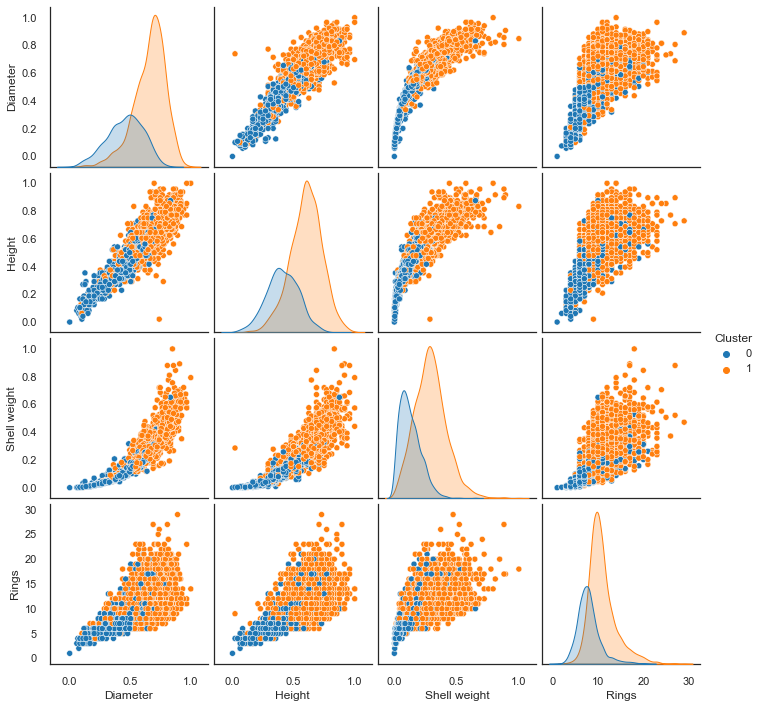

In [126]:
sns.set_theme(style="white")
sns.pairplot(data_encoded_clustered_k_means, hue='Cluster', palette='tab10')
# plt.savefig('images/11 splom after clustering.png',bbox_inches = 'tight');

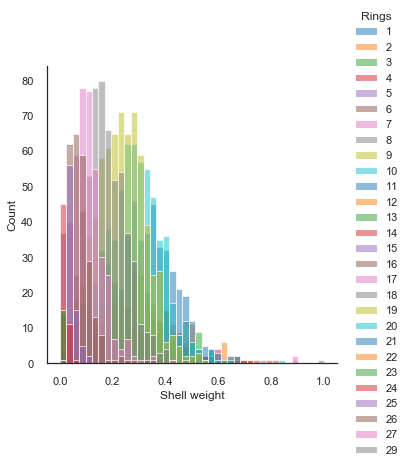

In [348]:
sns.displot(data_encoded_clustered, x="Shell weight", hue="Rings", palette='tab10')

In [405]:
order = [0,1,2,3,4,5]

In [413]:
handles_plot = [handles[idx] for idx in order]

In [415]:
labels_plot = [print(labels[idx]) for idx in order]

1
4
3
5
0
2


In [ ]:
labels

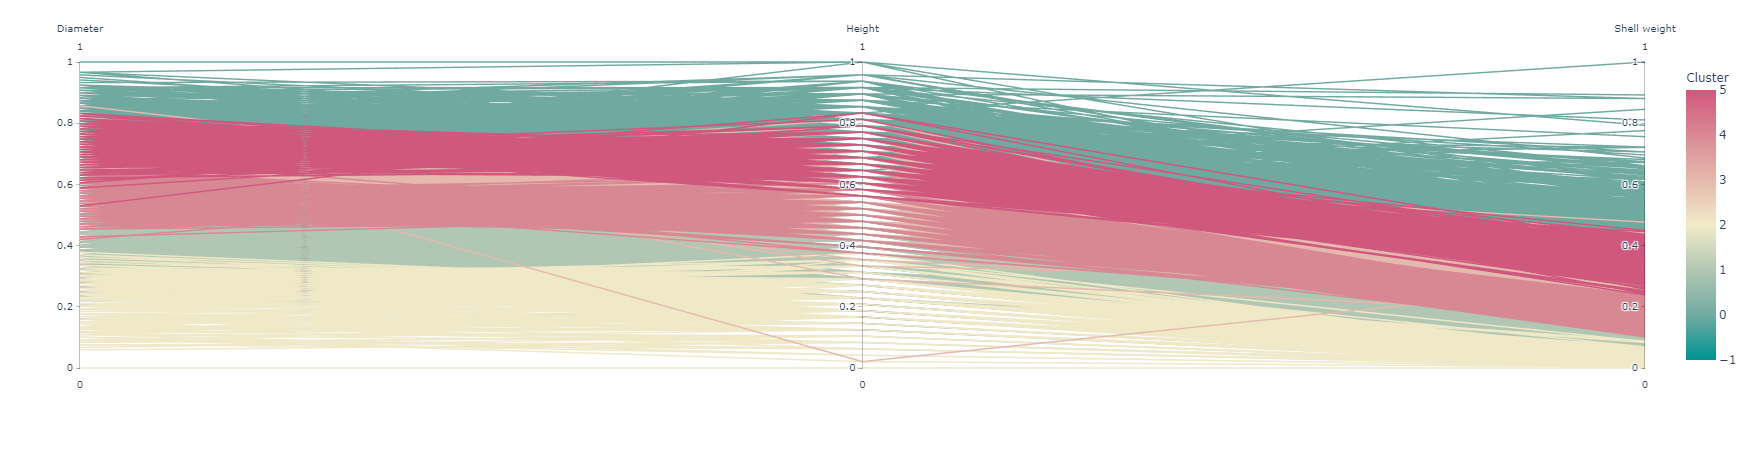

In [394]:
import plotly.express as px
fig = px.parallel_coordinates(data_encoded_clustered[['Diameter', 'Height', 'Shell weight', 'Cluster']], color="Cluster",
                              dimensions=['Diameter', 'Height', 'Shell weight'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()

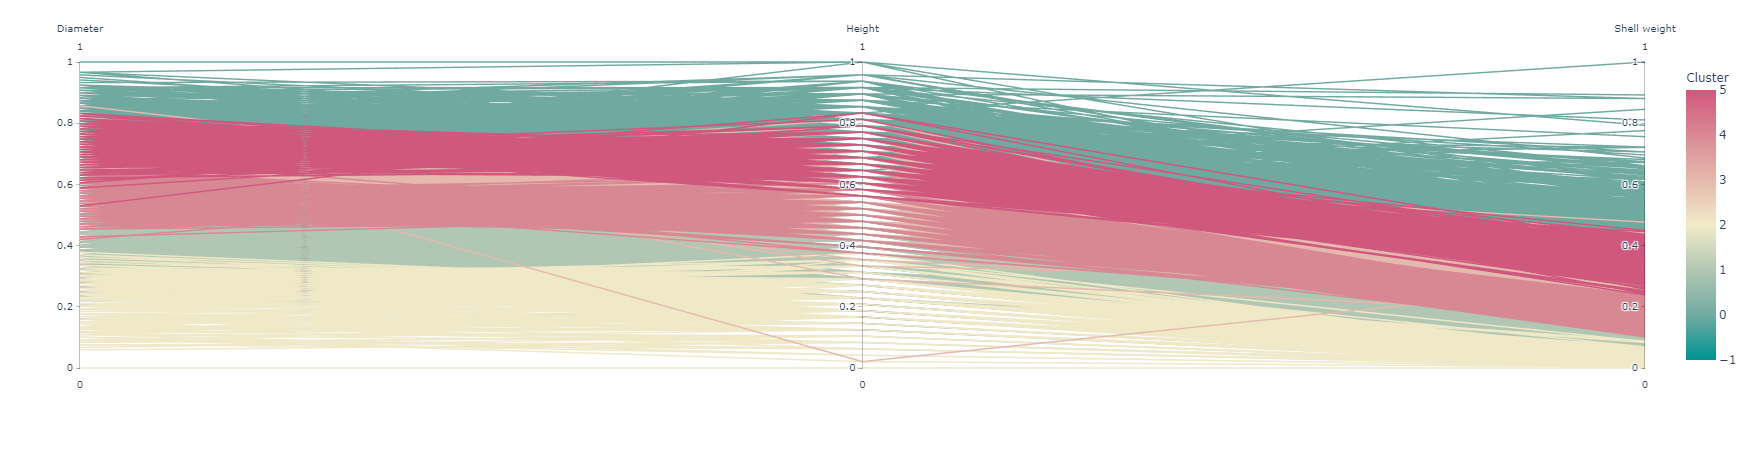

In [396]:
fig.show()

In [365]:
data_encoded_clustered[['Diameter', 'Height', 'Shell weight', 'Cluster']].sort_values('Cluster')

Diameter    Height  Shell weight  Cluster
2086  0.840336  0.708333      0.490284        0
1758  0.857143  0.854167      0.571500        0
1759  0.907563  0.812500      0.626308        0
1760  0.949580  0.770833      0.638266        0
1761  0.966387  1.000000      0.574489        0
...        ...       ...           ...      ...
1916  0.689076  0.625000      0.295466        5
1515  0.773109  0.708333      0.392128        5
1917  0.731092  0.645833      0.349278        5
1919  0.697479  0.708333      0.318386        5
1678  0.773109  0.687500      0.392128        5

[4173 rows x 4 columns]

In [167]:
model = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="average")
model = model.fit(data_encoded[cont_cols])

data_encoded_clustered = pd.concat([data_encoded[cont_cols],pd.Series(model.labels_)], axis=1)
data_encoded_clustered = data_encoded_clustered.rename(columns={0:'Cluster'})

In [209]:
total_dist = 0
for centroid in range(clf.centroids_.shape[0]):

    centroid_dist = 0
    for i in list(data_encoded_clustered[data_encoded_clustered['Cluster'] == 1].index):

        centroid_dist = centroid_dist + np.square(list(data_encoded_clustered[cont_cols].loc[i]) - clf.centroids_[centroid]).sum()

    total_dist = total_dist + centroid_dist

In [210]:
total_dist

114.72547925085624

In [187]:
clf.centroids_.shape[0]

5

In [203]:
np.square(list(data_encoded[cont_cols].loc[0]) - clf.centroids_[0]).sum()

0.5262160920319481

In [198]:
data_encoded_clustered

Length  Diameter    Height  Whole weight  Shucked weight  \
0     0.513514  0.521008  0.354167      0.181335        0.150303   
1     0.371622  0.352941  0.333333      0.079157        0.066241   
2     0.614865  0.613445  0.520833      0.239065        0.171822   
3     0.493243  0.521008  0.479167      0.182044        0.144250   
4     0.344595  0.336134  0.291667      0.071897        0.059516   
...        ...       ...       ...           ...             ...   
4168  0.662162  0.663866  0.645833      0.313441        0.248151   
4169  0.695946  0.647059  0.520833      0.341420        0.294553   
4170  0.709459  0.705882  0.812500      0.415796        0.352724   
4171  0.743243  0.722689  0.583333      0.386931        0.356422   
4172  0.858108  0.840336  0.770833      0.689393        0.635171   

      Viscera weight  Shell weight  Cluster  
0           0.132324      0.147982        3  
1           0.063199      0.068261        2  
2           0.185648      0.207773        3  
3           0.149440      0.152965        3  
4           0.051350      0.053313        2  
...              ...           ...      ...  
4168        0.314022      0.246637        3  
4169        0.281764      0.258097        3  
4170        0.377880      0.305431        0  
4171        0.342989      0.293473        0  
4172        0.495063      0.491779        0  

[4173 rows x 8 columns]